In [6]:
import matplotlib.pyplot as plt
import random
import math
from itertools import permutations
import numpy as np

In [7]:
class City:
    ''' 
    This class represents a City as a dot on the map with x,y coordinates and a name to identify the city.
    '''

    def __init__(self, x, y, name) -> None:
        self.x = x
        self.y  = y
        self.name = name

    def coordinates(self):
        return self.x, self.y


class TSPmap:
    '''
    This class contains a dictionary of the cities, accesable thought the city names and also
    helper functions to compute metrics, generate routes and plot routes and cities.
    '''
    cities = {}

    '''coordinates'''
    def cities_x(self):
        return list(map(lambda c: c.x, list(self.cities.values())))
    
    def cities_y(self):
        return list(map(lambda c: c.y, list(self.cities.values())))
    
    '''distance'''
    def city_distance(self, city1, city2):
        if type(city1) != City and type(city2) != City:
            c1 = self.cities[city1]
            c2 = self.cities[city2]
            return math.sqrt((c1.x - c2.x)**2 + (c1.y - c2.y)**2)
        return math.sqrt((city1.x - city2.x)**2 + (city1.y - city2.y)**2)
    
    def route_distance(self, route):
        distance = 0
        for name1, name2 in zip(route, np.append(route[1:],[route[0]])):
                distance += self.city_distance(self.cities[name1], self.cities[name2])
        return distance

    '''routes'''
    def generate_route(self):
        route = list(range(len(self.cities)))
        random.shuffle(route)
        return route
    
    def generate_routes(self, N):
        shuffles = []
        names = list(range(len(self.cities.values())))
        for _ in range(N):
            random.shuffle(names)
            shuffles.append(names.copy())
        return shuffles
    
    def route_fitness(self, route):
        return 1 / float(self.route_distance(route))

    '''plotting'''
    def plot_map(self):
        fig = plt.figure()
        plt.scatter(self.cities_x(), self.cities_y())
        plt.show()

    def plot_route(self, route):
        for name1, name2 in zip(route, np.append(route[1:], [route[0]])):
            x1, y1 = self.cities[name1].coordinates()
            x2, y2 = self.cities[name2].coordinates()
            plt.plot([x1, x2], [y1, y2], 'blue')

    def predef_plot_route(self, predef_plot, route):
        for name1, name2 in zip(route, np.append(route[1:], [route[0]])):
            x1, y1 = self.cities[name1].coordinates()
            x2, y2 = self.cities[name2].coordinates()
            predef_plot.plot([x1, x2], [y1, y2], 'blue')
            

    


In [8]:
tsp_map = TSPmap()

# read the file-tsp and serialize into the TSP map and City classes
with open('file-tsp.txt') as f:
    name = 0
    for line in f:
        line = line.strip()
        x = float(line[:7])
        y = float(line[7:].strip())
        tsp_map.cities[name] = City(x, y, str(name))
        name +=1


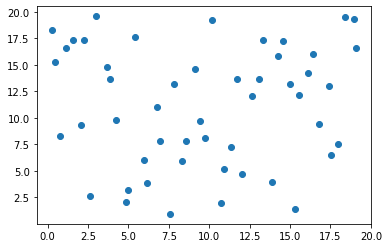

In [9]:
# plot the map, every dot is a city
tsp_map.plot_map()

In [10]:
# example of a generated route
route = tsp_map.generate_route()
print(route)

[38, 25, 29, 2, 39, 22, 46, 27, 23, 12, 5, 34, 13, 16, 24, 44, 43, 30, 33, 4, 10, 32, 7, 48, 37, 17, 15, 31, 19, 20, 41, 28, 26, 47, 14, 36, 3, 8, 40, 0, 49, 42, 9, 18, 21, 35, 11, 45, 6, 1]


0.002061148843955229

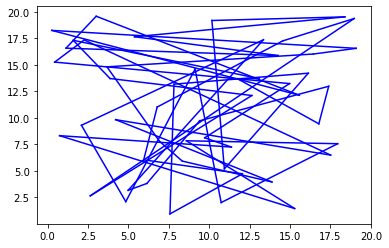

In [11]:
# plot the generated route and print its fitness
tsp_map.plot_route(route)
tsp_map.route_fitness(route)

In [12]:
# crossover two parent routes using the method from the slides
def crossover_routes(parent1, parent2):
    L = len(parent1)
    cp1, cp2 =  random.sample(range(L), 2)
    child1 = parent1[cp1:cp2]
    child2 = parent2[cp1:cp2]
    parent1 = list(filter(lambda x: x not in child2, parent1))
    parent2 = list(filter(lambda x: x not in child1, parent2))
    child1 =  np.append(np.append(parent2[(cp2-L):], child1), parent2[:(cp2-L)])
    child2 =  np.append(np.append(parent1[(cp2-L):], child2), parent1[:(cp2-L)])
    return child1, child2

# mutate a route by swapping the values of two random indexes
def mutate_route(route):
    L = len(route)
    index1, index2 = random.sample(range(L), 2)
    swap_name = route[index1]
    route[index1] = route[index2]
    route[index2] = swap_name
    return route

# 'mate' two routes to spawn 2 children
def mate_routes(parent1, parent2, probability, rate):
    child1 = []
    child2 = []
    if (np.random.choice(a=[True, False], p=[probability, 1-probability])):
        child1, child2 = crossover_routes(parent1, parent2)
    else:
        child1 = parent1
        child2 = parent2
    if (np.random.choice(a=[True, False], p=[rate, 1-rate])):
        child1 = mutate_route(child1)
    if (np.random.choice(a=[True, False], p=[rate, 1-rate])):
        child2 = mutate_route(child2)
    return child1, child2

# determine the fittest route and its corresponding fitnes out of a list of routes
def fittest_route(tspmap, routes):
    fitness = list(map((lambda r: tspmap.route_fitness(r)), routes))
    best_route_index = np.argmax(fitness)
    return routes[best_route_index], fitness[best_route_index]



In [13]:

def evolve_route(tspmap : TSPmap, population, tournament_size, pc, u):
    """
    run simple Evolution Algorithm on a population of lists
    num_generations = number of generations
    tournament size = size of the pool from which the best candidate is selected
    pc = crossover probability
    u = mutation rate

    returns a list with the next generation
    """

    breeding_population = []
    while len(breeding_population) <= len(population):
        pool = random.sample(population, tournament_size)
        fitness = list(map((lambda r: tspmap.route_fitness(r)), pool))
        best_route_index = np.argmax(fitness)
        breeding_population.append(pool[best_route_index])
    
    next_generation = []
    
    parents1, parents2 = np.array_split(breeding_population, 2)
    for parent1, parent2 in zip(parents1, parents2):
        child1, child2 = mate_routes(parent1, parent2, pc, u)
        next_generation.append(child1)
        next_generation.append(child2)

    return next_generation
    

In [14]:
def local_search(map, route):
    """
    permorm local search on a route and return the improved version if there is one
    """

    for index in range(0, len(route)-1): #iterate over all pairs in the route
        c1 = route[index]
        c2 = route[index+1]              
        for swap_index in range(0, len(route)-1):
            if (swap_index == index or swap_index == index+1): # make sure the swap pair contains different cities
                continue
            swapc1 = route[swap_index]
            swapc2 = route[swap_index+1]

            current_distance = map.city_distance(c1, c2) + map.city_distance(swapc1, swapc2) # distance between the pairs in the current route

            for swapindex1, swapindex2 in [[swap_index, swap_index+1], [swap_index+1, swap_index]]:
                swapped_distance = map.city_distance(c1, route[swapindex1]) + map.city_distance(route[swapindex2], c2)
                if current_distance > swapped_distance:
                    new_route = []
                    new_route = route[:index]
                    new_route = np.flip(route[index+1:swapindex1])
                    new_route = route[swapindex2:]
                    return new_route
    return route



In [15]:

def evolve_route_memetic(tspmap : TSPmap, population, tournament_size, pc, u):
    """
    run simple Evolution Algorithm on a population of lists with additional local search
    num_generations = number of generations
    tournament size = size of the pool from which the best candidate is selected
    pc = crossover probability
    u = mutation rate

    returns a list with the next generation
    """

    breeding_population = []
    while len(breeding_population) <= len(population):
        pool = random.sample(population, tournament_size)
        fitness = list(map((lambda r: tspmap.route_fitness(r)), pool))
        best_route_index = np.argmax(fitness)
        breeding_population.append(pool[best_route_index])
    next_generation = []
    parents1, parents2 = np.array_split(breeding_population, 2)
    for parent1, parent2 in zip(parents1, parents2):
        child1, child2 = mate_routes(parent1, parent2, pc, u)
        next_generation.append(child1)
        next_generation.append(child2)

        local_search(tspmap, child1)
        local_search(tspmap, child2)

    return next_generation

In [16]:
from IPython.display import clear_output, display

def evolution_algorithm(tspmap : TSPmap, start_population, num_generations, tournament_size, pc, u, memetic, 
                        show_graph = False, animated_graph=False):
    """
    Run the EA with the specified parameters, will use the memetic version of the algorithm if memetic is set to True.
    If animated_graph is True the graph will be updated every 10 generations, otherwise the whole graph is plotted when the loop terminates
    """
    population = start_population
    fitness_history = []
    distance_history = []

    for g in range(num_generations):
        # evolve the population to the next generation
        if memetic:
            next_population = evolve_route_memetic(tspmap, population, tournament_size, pc, u)
        else:
            next_population = evolve_route(tspmap, population, tournament_size, pc, u)
        # select the fittest route from the new generation
        best_gen_route, best_gen_fitness = fittest_route(tspmap, next_population)
        best_gen_distance = tspmap.route_distance(best_gen_route)

        distance_history.append(best_gen_distance)
        fitness_history.append(best_gen_fitness)
        population = next_population

        if animated_graph:
            if (g % 10 == 0):
                plt.plot(list((range(0,g+1))), distance_history, 'blue')
                plt.ylabel('total distance')
                plt.xlabel('generations')
                display(plt.gcf())
                clear_output(wait=True)

    if show_graph:
        plt.plot(list((range(0,g+1))), distance_history, 'blue')
        plt.ylabel('total distance')
        plt.xlabel('generations')
        display(plt.gcf())
        clear_output(wait=True)

    return population, distance_history, fitness_history


In [25]:

def run_ea_and_plot_results(tspmap, number_of_runs, N, num_generations, tournament_size, pc, u):

    fig, axes = plt.subplots(2,2)
    fig.tight_layout(pad=0.3)
    fig.set_size_inches(10,10)

    axes[0][0].sharey(axes[1][0])

    for memetic in [False, True]:

        assignment_tsp = []
        for run in range(number_of_runs):
            population, distance, fitness = evolution_algorithm(tspmap, tspmap.generate_routes(N), num_generations, tournament_size, pc, u, memetic)
            assignment_tsp.append([population, distance, fitness])

        best_run = assignment_tsp[np.argmax(map((lambda x: x[2][-1]), assignment_tsp))]
        avg_run = np.sum(list(map((lambda x: x[1:]), assignment_tsp)), 1)

        avgplot = axes[int(memetic)][0]
        avgplot.plot(list((range(0, num_generations))), avg_run[0])
        avgplot.set_ylabel('distance traveled')
        if memetic:
            avgplot.set_title('memetic EA')
            avgplot.set_xlabel('time (generations)')
        else:
            avgplot.set_title('simple EA')

        best_route, best_route_fitness = fittest_route(tsp_map, best_run[0])
        routeplot = axes[int(memetic)][1]
        tsp_map.predef_plot_route(routeplot, best_route)
        routeplot.get_xaxis().set_visible(False)
        routeplot.get_yaxis().set_visible(False)


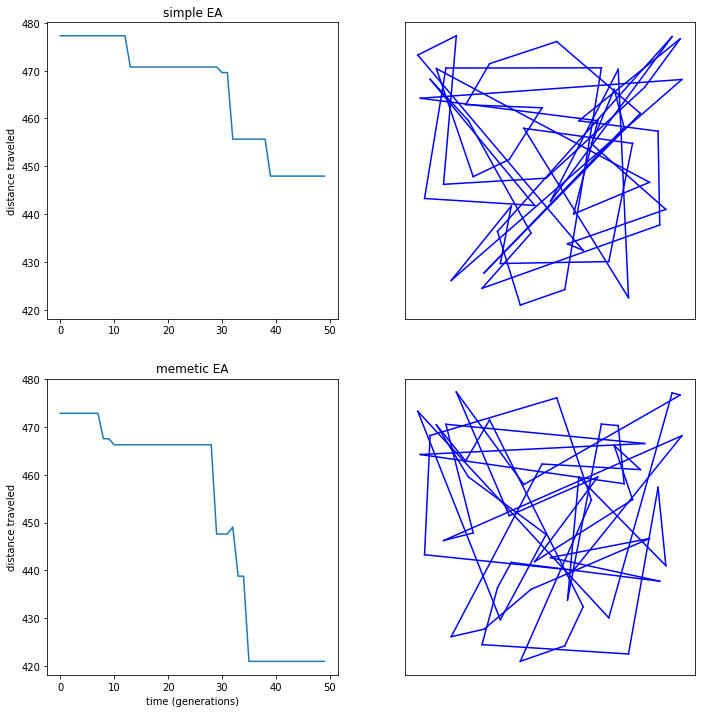

In [26]:

N = 10 # population size
num_generations = 50 # number of generation to run the evolution algorithm
tournament_size = 2 # pool size for the tournament selection

pc = 0.1 # crossover probability
u = 0.01 # mutation rate

number_of_runs = 2 # number of times to run the EA algorithm

run_ea_and_plot_results(tsp_map, number_of_runs, N, num_generations, tournament_size, pc, u)

In [37]:
berlin_map = TSPmap()

# read the file-tsp and serialize into the TSP map and City classes
with open('berlin52.tsp') as f:
    for _ in range(6):
        f.readline()
    for line in f:
        line = line.strip()
        elems = line.split(' ')
        if len(elems) < 3:
            break
        
        x = float(elems[1])
        y = float(elems[2].strip())
        name = int(elems[0])
        tsp_map.cities[name] = City(x, y, str(name))

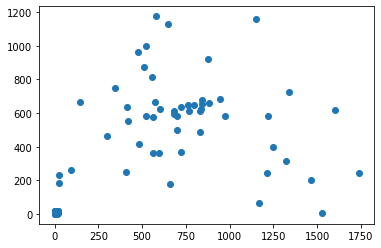

In [34]:
berlin_map.plot_map()

KeyError: 87

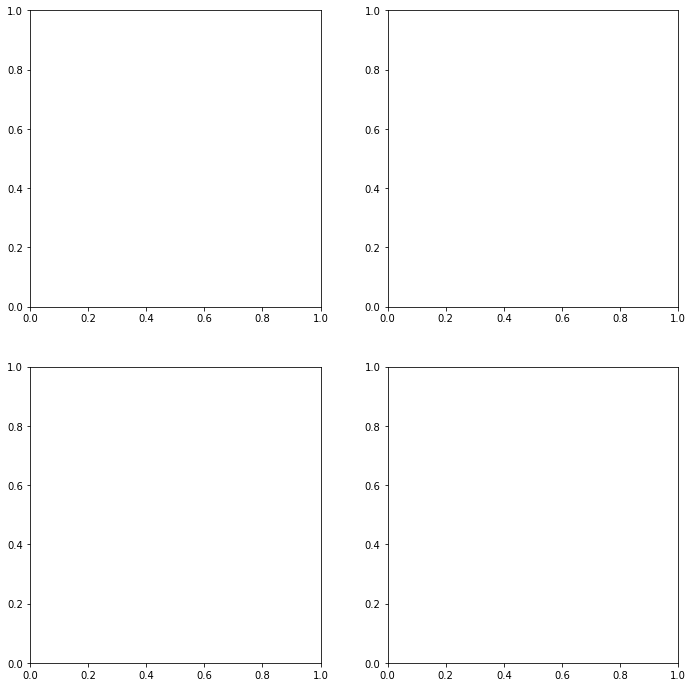

In [38]:
run_ea_and_plot_results(berlin_map, number_of_runs, N, num_generations, tournament_size, pc, u)
